In [1]:
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

In [12]:
# Load the data
file_path = r'Cleaned_Accident_Dataset.xlsx'
df = pd.read_excel(file_path)

# Rename columns and clean the data - TEMPORARY
df.columns = [
    'Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
    'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
    'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
    'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
    'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
    'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
    'Type_of_collision', 'Number_of_vehicles_involved', 'Number_of_casualties',
    'Vehicle_movement', 'Casualty_class', 'Sex_of_casualty',
    'Age_band_of_casualty', 'Casualty_severity', 'Work_of_casuality',
    'Fitness_of_casuality', 'Pedestrian_movement', 'Cause_of_accident',
    'Accident_severity'
]
df.head()

Time Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0  17:20:00      Friday              18-30          Male  Junior high school   
1  17:20:00      Friday              18-30          Male  Junior high school   
2  17:45:00    Thursday              18-30          Male  Junior high school   
3  17:45:00    Thursday              31-50          Male  Junior high school   
4  17:45:00    Thursday              31-50          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee         Above 10yr      Lorry (41?100Q)   
1                Employee              1-2yr           Automobile   
2                Employee              1-2yr  Public (> 45 seats)   
3                Employee             5-10yr      Lorry (41?100Q)   
4                Employee         Above 10yr           Automobile   

  Owner_of_vehicle Service_year_of_vehicle  ... Vehicle_movement  \
0            Owner                   1-2yr  ...   Going straight   
1            Owner                  2-5yrs  ...           U-Turn   
2            Owner                  2-5yrs  ...   Going straight   
3            Owner              Above 10yr  ...    Waiting to go   
4            Owner                   1-2yr  ...   Going straight   

    Casualty_class Sex_of_casualty Age_band_of_casualty Casualty_severity  \
0       Pedestrian            Male             Under 18                 3   
1        Passenger            Male                18-30                 3   
2               na              na                   na                na   
3               na              na                   na                na   
4  Driver or rider          Female                18-30                 3   

  Work_of_casuality Fitness_of_casuality              Pedestrian_movement  \
0            Driver               Normal  Crossing from driver's nearside   
1            Driver               Normal                 Not a Pedestrian   
2            Driver               Normal                 Not a Pedestrian   
3             Other               Normal                 Not a Pedestrian   
4            Driver               Normal                 Not a Pedestrian   

            Cause_of_accident Accident_severity  
0  Changing lane to the right     Slight Injury  
1             Moving Backward    Serious Injury  
2               No distancing     Slight Injury  
3      No priority to vehicle     Slight Injury  
4               No distancing    Serious Injury  

[5 rows x 32 columns]

In [13]:
# Handling missing data for numerical features
num_imputer = SimpleImputer(strategy='mean')  # or median, most_frequent

# Handling missing data for categorical features
cat_imputer = SimpleImputer(strategy='most_frequent')

# Explicitly select numerical and categorical columns
num_columns = df.select_dtypes(include=['int64', 'float64']).columns
cat_columns = df.select_dtypes(include=['object']).columns

# Apply imputation
for col in num_columns:
    df[col] = num_imputer.fit_transform(df[[col]])

for col in cat_columns:
    # Reshape the output to 1D using .ravel()
    df[col] = cat_imputer.fit_transform(df[[col]]).ravel()

# Handling inconsistency
# Convert 'Day_of_week' to string type before applying string methods
df['Day_of_week'] = df['Day_of_week'].astype(str).str.strip().str.capitalize()
df['Sex_of_driver'] = df['Sex_of_driver'].replace({'male':'Male', 'female':'Female'})
df

Time Day_of_week Age_band_of_driver Sex_of_driver  \
0     17:20:00      Friday              18-30          Male   
1     17:20:00      Friday              18-30          Male   
2     17:45:00    Thursday              18-30          Male   
3     17:45:00    Thursday              31-50          Male   
4     17:45:00    Thursday              31-50          Male   
...        ...         ...                ...           ...   
2884  17:25:00      Friday              31-50          Male   
2885  12:48:00      Friday              31-50          Male   
2886  13:55:00      Sunday            Over 51          Male   
2887  13:55:00      Sunday              18-30        Female   
2888  13:55:00      Sunday              18-30          Male   

       Educational_level Vehicle_driver_relation Driving_experience  \
0     Junior high school                Employee         Above 10yr   
1     Junior high school                Employee              1-2yr   
2     Junior high school                Employee              1-2yr   
3     Junior high school                Employee             5-10yr   
4     Junior high school                Employee         Above 10yr   
...                  ...                     ...                ...   
2884  Junior high school                Employee             5-10yr   
2885  Junior high school                Employee              2-5yr   
2886  Junior high school                Employee             5-10yr   
2887  Junior high school                Employee         Above 10yr   
2888  Junior high school                Employee             5-10yr   

          Type_of_vehicle Owner_of_vehicle Service_year_of_vehicle  ...  \
0         Lorry (41?100Q)            Owner                   1-2yr  ...   
1              Automobile            Owner                  2-5yrs  ...   
2     Public (> 45 seats)            Owner                  2-5yrs  ...   
3         Lorry (41?100Q)            Owner              Above 10yr  ...   
4              Automobile            Owner                   1-2yr  ...   
...                   ...              ...                     ...  ...   
2884           Automobile            Owner                   1-2yr  ...   
2885           Automobile            Owner                 Unknown  ...   
2886                Bajaj            Owner                  2-5yrs  ...   
2887      Lorry (41?100Q)            Owner                  2-5yrs  ...   
2888                Other            Owner                  2-5yrs  ...   

     Vehicle_movement   Casualty_class Sex_of_casualty Age_band_of_casualty  \
0      Going straight       Pedestrian            Male             Under 18   
1              U-Turn        Passenger            Male                18-30   
2      Going straight               na              na                   na   
3       Waiting to go               na              na                   na   
4      Going straight  Driver or rider          Female                18-30   
...               ...              ...             ...                  ...   
2884            Other               na              na                   na   
2885   Going straight  Driver or rider          Female              Over 51   
2886            Other  Driver or rider            Male                31-50   
2887            Other               na              na                   na   
2888         Stopping       Pedestrian          Female                    5   

     Casualty_severity Work_of_casuality Fitness_of_casuality  \
0                    3            Driver               Normal   
1                    3            Driver               Normal   
2                   na            Driver               Normal   
3                   na             Other               Normal   
4                    3            Driver               Normal   
...                ...               ...                  ...   
2884                na     Self-employed               Normal   
2885                 3        

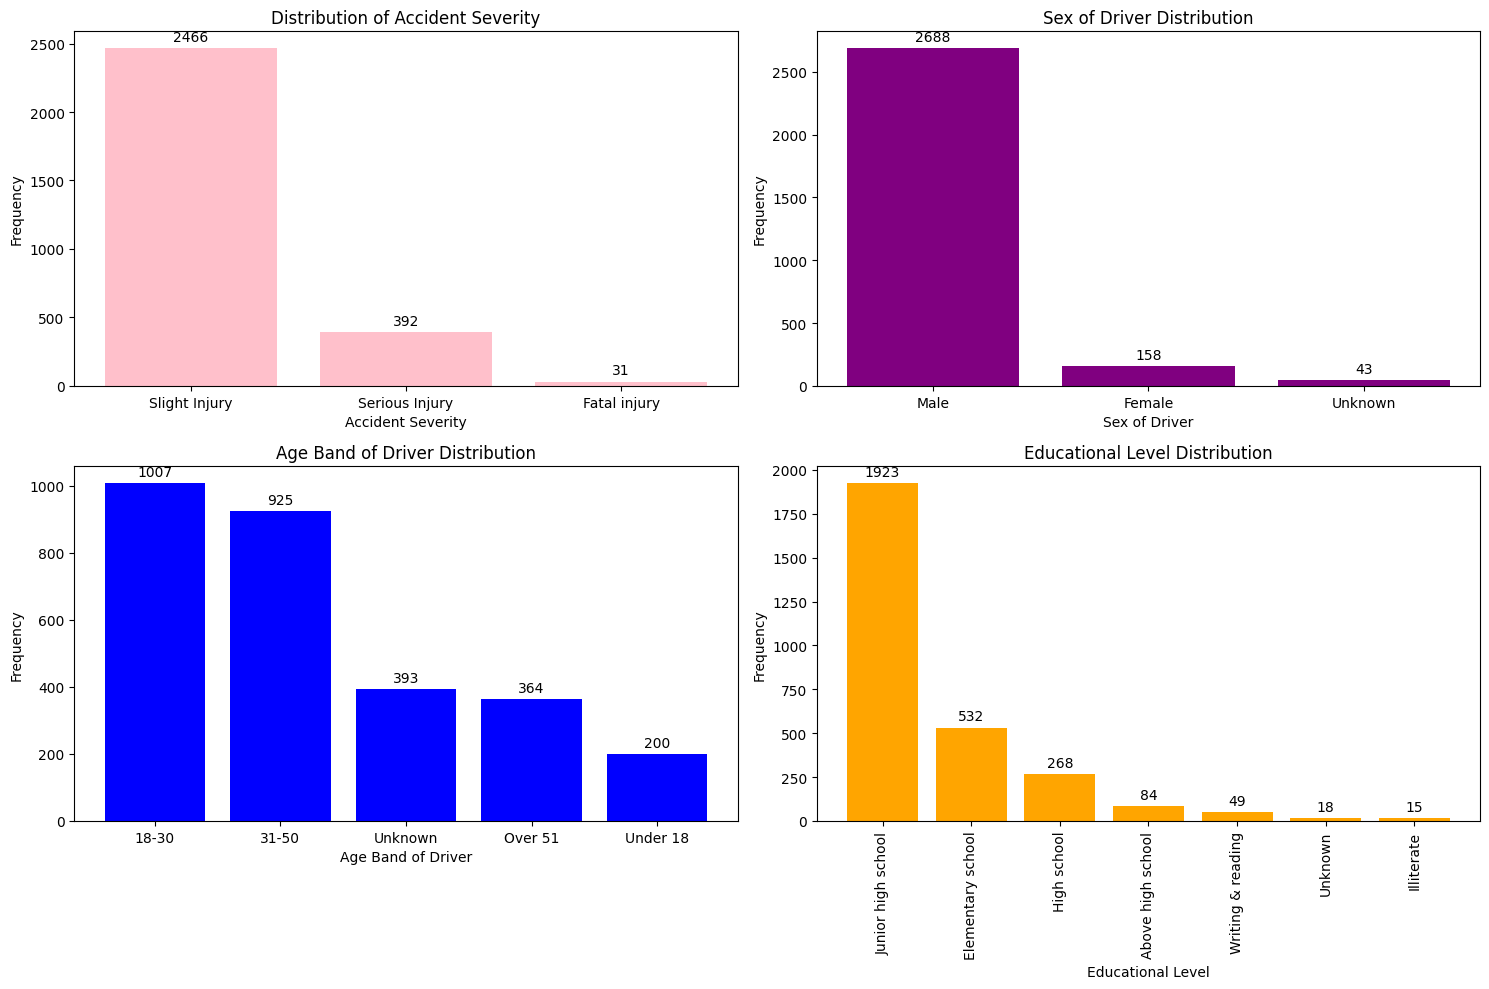

In [14]:
import matplotlib.pyplot as plt

# Set up the matplotlib figure and axes
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# 'Accident_severity' bar chart
severity_counts = df['Accident_severity'].value_counts()
axs[0, 0].bar(severity_counts.index.astype(str), severity_counts.values, color='pink')
axs[0, 0].set_title('Distribution of Accident Severity')
axs[0, 0].set_xlabel('Accident Severity')
axs[0, 0].set_ylabel('Frequency')

# 'Sex_of_driver' bar chart
sex_of_driver_counts = df['Sex_of_driver'].value_counts()
axs[0, 1].bar(sex_of_driver_counts.index.astype(str), sex_of_driver_counts.values, color='purple')
axs[0, 1].set_title('Sex of Driver Distribution')
axs[0, 1].set_xlabel('Sex of Driver')
axs[0, 1].set_ylabel('Frequency')

# 'Age_band_of_driver' bar chart
age_band_of_driver_counts = df['Age_band_of_driver'].value_counts()
axs[1, 0].bar(age_band_of_driver_counts.index.astype(str), age_band_of_driver_counts.values, color='blue')
axs[1, 0].set_title('Age Band of Driver Distribution')
axs[1, 0].set_xlabel('Age Band of Driver')
axs[1, 0].set_ylabel('Frequency')

# 'Educational_level' bar chart
educational_level_counts = df['Educational_level'].value_counts()
bars = axs[1, 1].bar(educational_level_counts.index.astype(str), educational_level_counts.values, color='orange')
axs[1, 1].set_title('Educational Level Distribution')
axs[1, 1].set_xlabel('Educational Level')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_xticklabels(educational_level_counts.index.astype(str), rotation=90)

# Add annotations to each bar
for ax in axs.flat:
    for bar in ax.patches:
        ax.annotate(f'{int(bar.get_height())}',
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black',
                    xytext=(0, 3), textcoords='offset points')

# Adjust the layout
plt.tight_layout()

# Show the figure with subplots
plt.show()

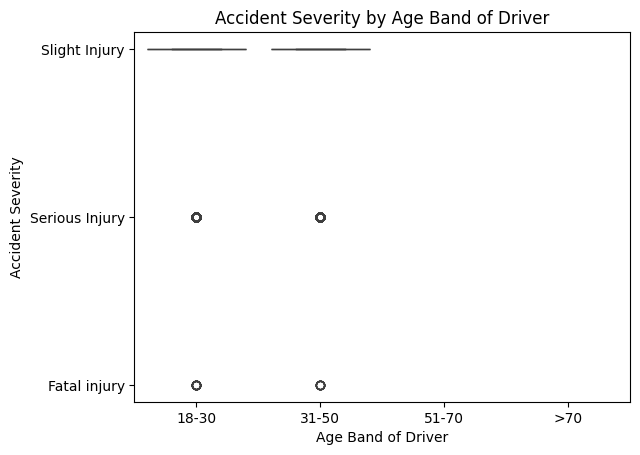

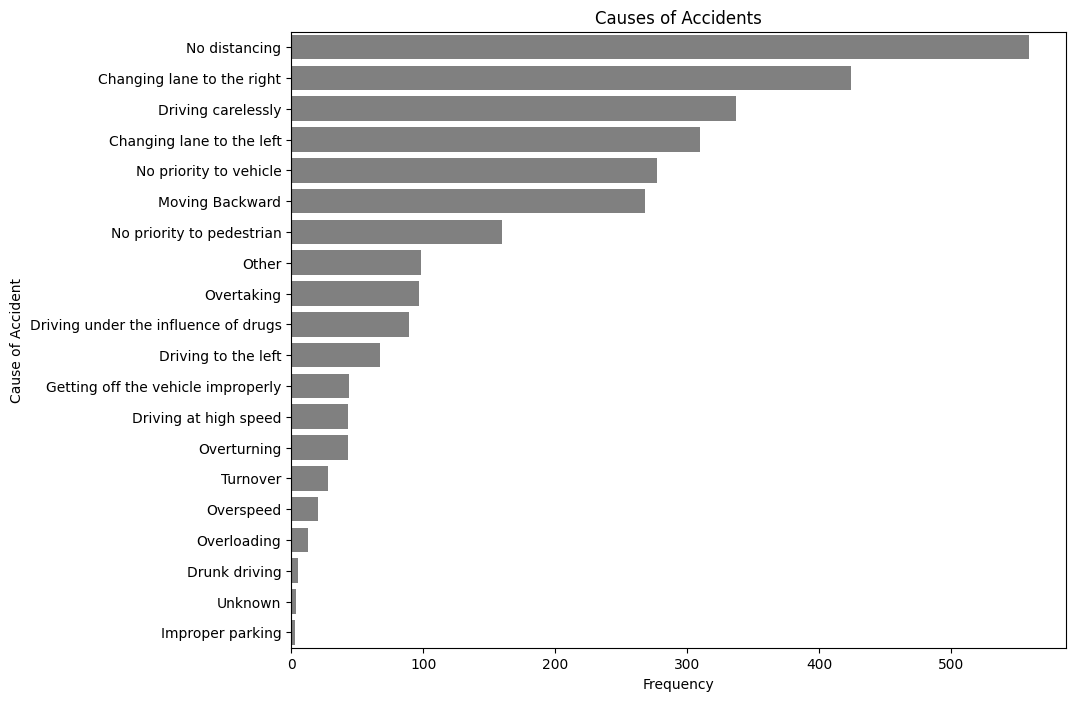

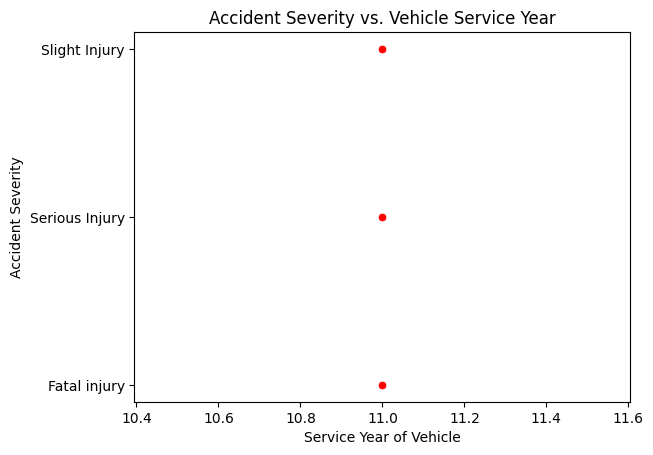

In [15]:
# Driver Age Band vs. Accident Severity
sns.boxplot(x='Age_band_of_driver', y='Accident_severity', data=df, order=['18-30', '31-50', '51-70', '>70'])
plt.title('Accident Severity by Age Band of Driver')
plt.xlabel('Age Band of Driver')
plt.ylabel('Accident Severity')
plt.show()

# Causes of Accidents
plt.figure(figsize=(10, 8))
sns.countplot(y='Cause_of_accident', data=df, order=df['Cause_of_accident'].value_counts().index, color='gray')
plt.title('Causes of Accidents')
plt.xlabel('Frequency')
plt.ylabel('Cause of Accident')
plt.show()

# Vehicle Service Year vs. Accident Severity
df['Service_year_of_vehicle'] = df['Service_year_of_vehicle'].replace('Above 10yr', '11')
df['Service_year_of_vehicle'] = pd.to_numeric(df['Service_year_of_vehicle'], errors='coerce')
sns.scatterplot(x='Service_year_of_vehicle', y='Accident_severity', data=df, color='red')
plt.title('Accident Severity vs. Vehicle Service Year')
plt.xlabel('Service Year of Vehicle')
plt.ylabel('Accident Severity')
plt.show()

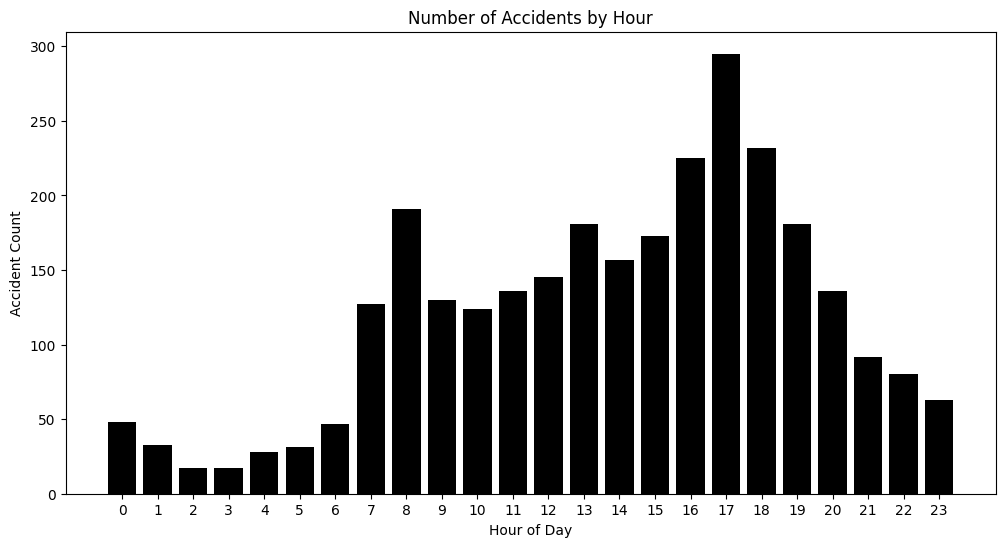

In [16]:
# Filter out rows with 'na' in the time column
df = df[df['Time'] != 'na']

# Convert the time column to datetime format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

# Extract the hour from the time
df['Hour_of_day'] = df['Time'].dt.hour

# Count the number of accidents for each hour
hourly_accidents = df['Hour_of_day'].value_counts().sort_index()

# Create a bar chart for the number of accidents by hour
plt.figure(figsize=(12, 6))
plt.bar(hourly_accidents.index, hourly_accidents.values, color='black')
plt.title('Number of Accidents by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Accident Count')

# Set x-axis ticks to show every hour
hours_in_day = range(24)
plt.xticks(hours_in_day)

plt.show()

In [17]:
# Drop added Hour of day column
df = df.drop('Hour_of_day', axis=1)

# List of columns to encode
columns_to_encode = [
    'Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
    'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
    'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
    'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
    'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
    'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
    'Type_of_collision', 'Number_of_vehicles_involved', 'Number_of_casualties',
    'Vehicle_movement', 'Casualty_class', 'Sex_of_casualty',
    'Age_band_of_casualty', 'Casualty_severity', 'Work_of_casuality',
    'Fitness_of_casuality', 'Pedestrian_movement', 'Cause_of_accident',
    'Accident_severity'
]

# Initialize the LabelEncoder
lab_encoder = preprocessing.LabelEncoder()

# Apply LabelEncoder to each column in the list
for col in columns_to_encode:
    if col in df.columns:  # Check if the column exists in the DataFrame
        df[col] = lab_encoder.fit_transform(df[col].astype(str))
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")

# Display the updated DataFrame
df

Time  Day_of_week  Age_band_of_driver  Sex_of_driver  Educational_level  \
0      515            0                   0              1                  4   
1      515            0                   0              1                  4   
2      534            4                   0              1                  4   
3      534            4                   1              1                  4   
4      534            4                   1              1                  4   
...    ...          ...                 ...            ...                ...   
2884   520            0                   1              1                  4   
2885   330            0                   1              1                  4   
2886   374            3                   2              1                  4   
2887   374            3                   0              0                  4   
2888   374            3                   0              1                  4   

      Vehicle_driver_relation  Driving_experience  Type_of_vehicle  \
0                           0                   3                5   
1                           0                   0                0   
2                           0                   0               11   
3                           0                   2                5   
4                           0                   3                0   
...                       ...                 ...              ...   
2884                        0                   2                0   
2885                        0                   1                0   
2886                        0                   2                1   
2887                        0                   3                5   
2888                        0                   2                7   

      Owner_of_vehicle  Service_year_of_vehicle  ...  Vehicle_movement  \
0                    3                        1  ...                 2   
1                    3                        1  ...                10   
2                    3                        1  ...                 2   
3                    3                        0  ...                12   
4                    3                        1  ...                 2   
...                ...                      ...  ...               ...   
2884                 3                        1  ...                 4   
2885                 3                        1  ...                 2   
2886                 3                        1  ...                 4   
2887                 3                        1  ...                 4   
2888                 3                        1  ...                 8   

      Casualty_class  Sex_of_casualty  Age_band_of_casualty  \
0                  2                1                     4   
1                  1                1                     0   
2                  3                2                     5   
3                  3                2                     5   
4                  0                0                     0   
...              ...              ...                   ...   
2884               3                2                     5   
2885               0                0                     3   
2886               0                1                     1   
2887               3                2                     5   
2888               2                0                     2   

      Casualty_severity  Work_of_casuality  Fitness_of_casuality  \
0                     2                  0                     2   
1                     2                  0                     2   
2                     3                  0                     2   
3                     3                  2                     2   
4                     2                  0                     2   
...                 ...                ...                   ...   
2884                  3                  3                     2   
28

In [18]:
# Split the data into features and target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.2, random_state = 42)

print(X_train.values)


[[395   0   4 ...   2   5  10]
 [145   6   3 ...   2   5  17]
 [157   6   4 ...   2   5   5]
 ...
 [352   6   0 ...   2   6   9]
 [173   6   4 ...   2   5  18]
 [294   1   1 ...   2   5   1]]


In [19]:

X_train
X_test
y_train
y_test

471     1
1206    2
2382    2
2013    2
2885    2
       ..
2105    2
133     1
1140    2
933     2
928     2
Name: Accident_severity, Length: 2312, dtype: int64

Model: Logistic Regression
Accuracy: 0.85
Precision: 0.34
Recall: 0.33
Kappa: 0.00
Computation Time: 0.06 seconds


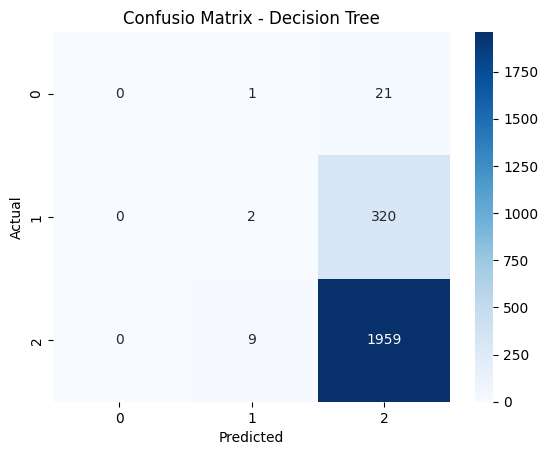

Model: Decision Tree
Accuracy: 0.74
Precision: 0.36
Recall: 0.36
Kappa: 0.06
Computation Time: 0.03 seconds


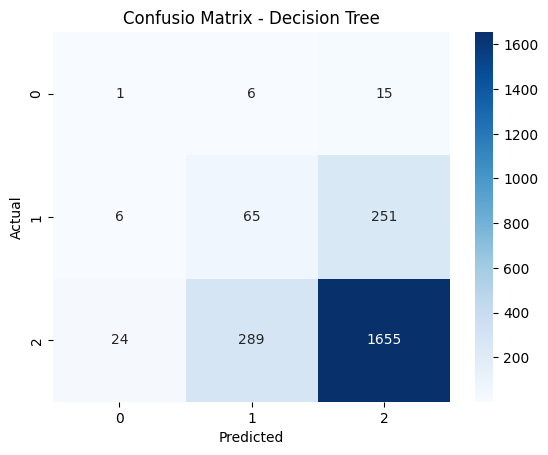

In [20]:
# Models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier()
}

# Descision Tree and Logistic Regression Model Training
for model_name, model in models.items():

    # Start the timer
    start_time = time.time()

    # Train the model
    model.fit(X_train, y_train)

    # Model Performance
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(y_test, y_pred)

    # Calculate computation time
    computation_time = time.time() - start_time

    # Display Model Performance
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"Computation Time: {computation_time:.2f} seconds")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusio Matrix - Decision Tree')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

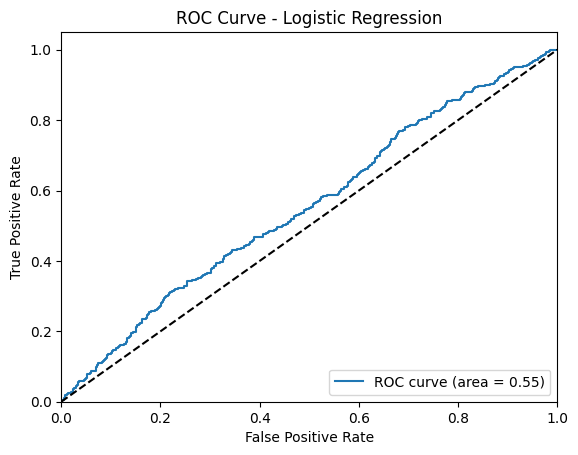

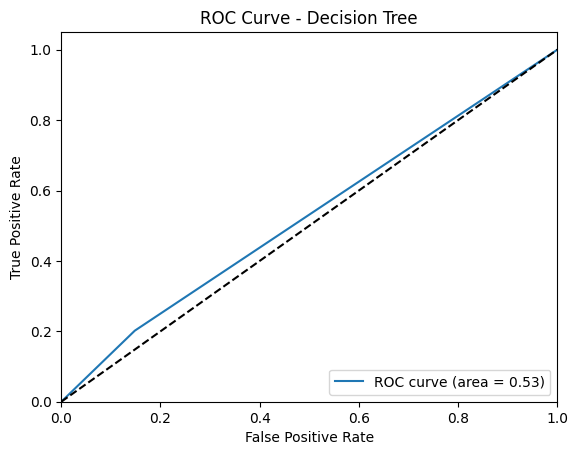

In [21]:
for model_name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

In [24]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc


# LIME
class_names = [str(cls) for cls in model.classes_]
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=class_names,
    discretize_continuous=True
)
instance_index = 0

# Ensure that predict_proba returns a 2D array with probabilities for each class
# even if it's a binary classification problem.
def predict_proba_wrapper(X):
    probs = model.predict_proba(X)
    # If probs is 1D (binary classification), reshape it to 2D
    if probs.ndim == 1:
        probs = probs.reshape(-1, 1)
        probs = np.hstack([1 - probs, probs])  # Assuming binary classification
    return probs

exp = explainer.explain_instance(X_test.values[instance_index], predict_proba_wrapper, num_features=10)
exp.show_in_notebook(show_table=True)

# LIME
class_names = [str(cls) for cls in model.classes_]
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=class_names,
    discretize_continuous=True
)
instance_index = 0
exp = explainer.explain_instance(X_test.values[instance_index], model.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)


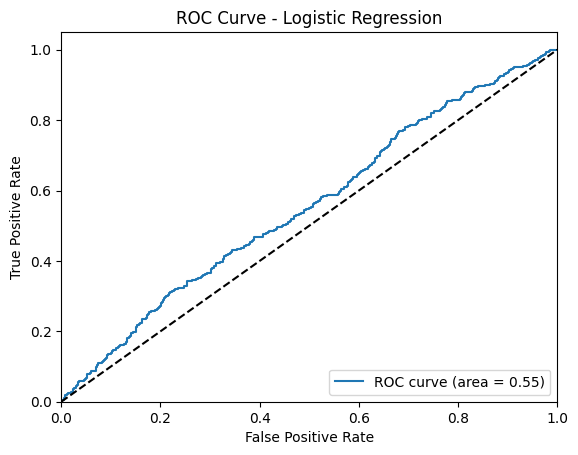

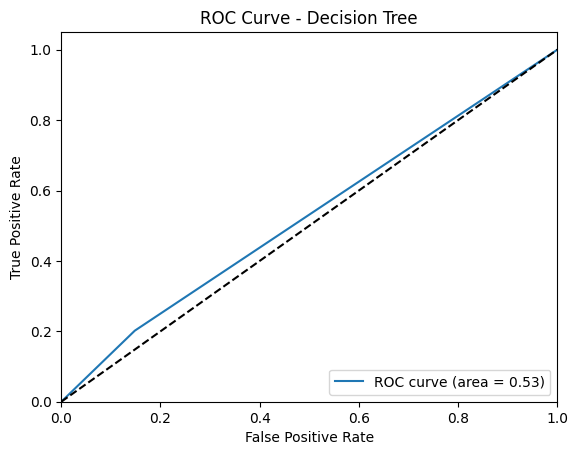

In [25]:
# ROC Curve
for model_name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    # plt.show()

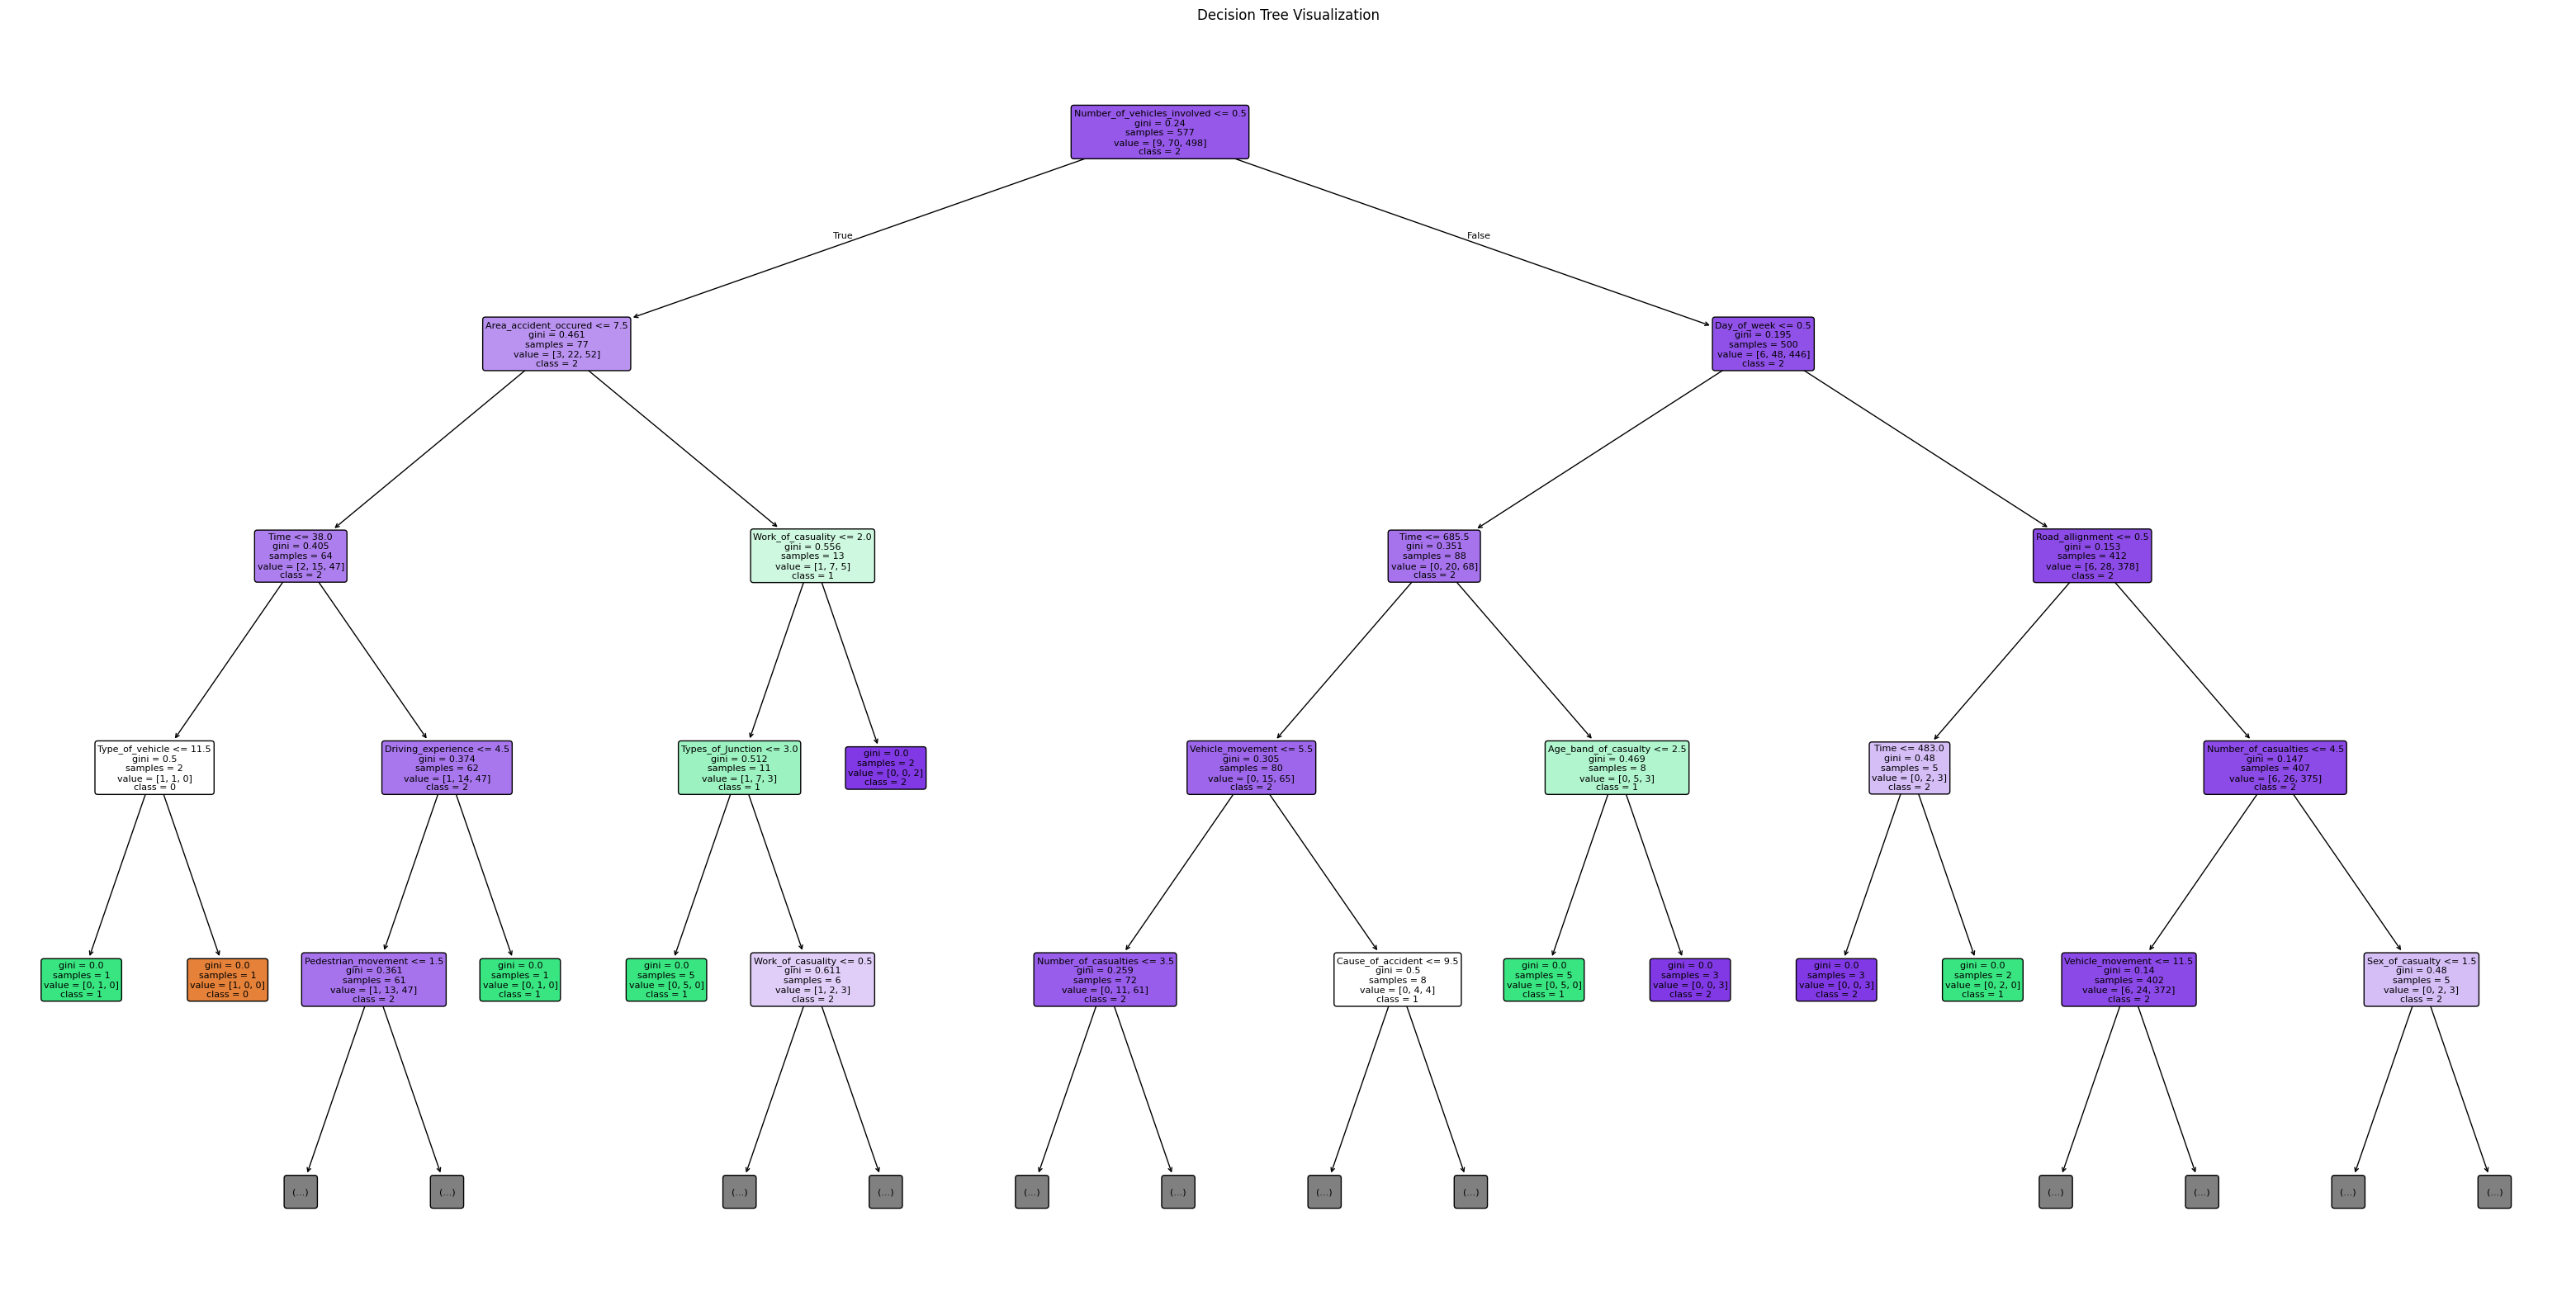

In [29]:
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree

# Plot the Decision Tree with zoomed-out view
for model_name in ['Decision Tree']:
    if model_name in models:
        model = models[model_name]
        plt.figure(figsize=(40, 20))  # Increase the figure size
        plot_tree(
          model,
          max_depth=4,  # Limit the depth of the visualization
          feature_names=X.columns,
          class_names=[str(cls) for cls in model.classes_],
          filled=True,
          rounded=True,
          fontsize=8
          )
        plt.title('Decision Tree Visualization')
        plt.show()


SHAP values calculated for model: Logistic Regression
Skipping SHAP explanation for unsupported model type: Logistic Regression
SHAP values calculated for model: Decision Tree


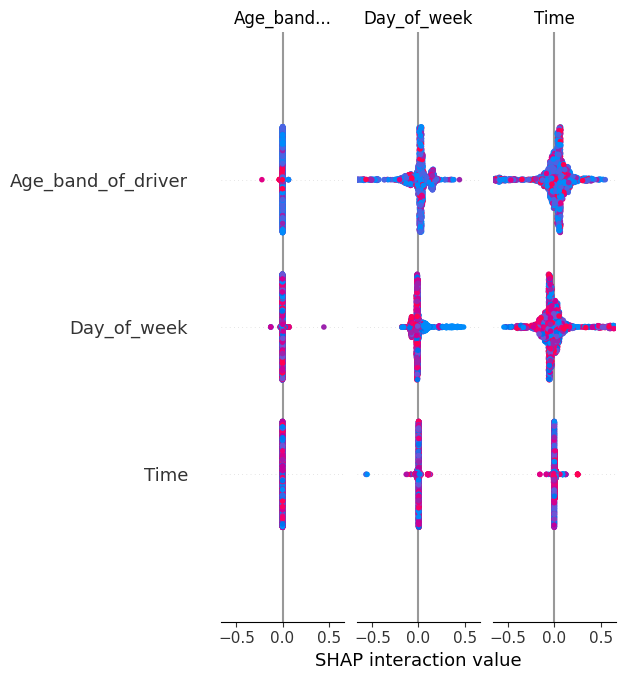

In [30]:
# SHAP
for model_name, model in models.items():
    print(f"SHAP values calculated for model: {model_name}")
    if model_name == 'Decision Tree':
        explainer = shap.TreeExplainer(model)
    # elif model_name == 'Logistic Regression':
    #     explainer = shap.KernelExplainer(model.predict_proba, X_train)
    else:
        print(f"Skipping SHAP explanation for unsupported model type: {model_name}")
        continue
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    instance_index = 0
    # shap.plots.force(explainer.expected_value, shap_values[instance_index], X_test.iloc[instance_index]) # Commented out due to potential errors

Partial Dependence Plot for model: Logistic Regression


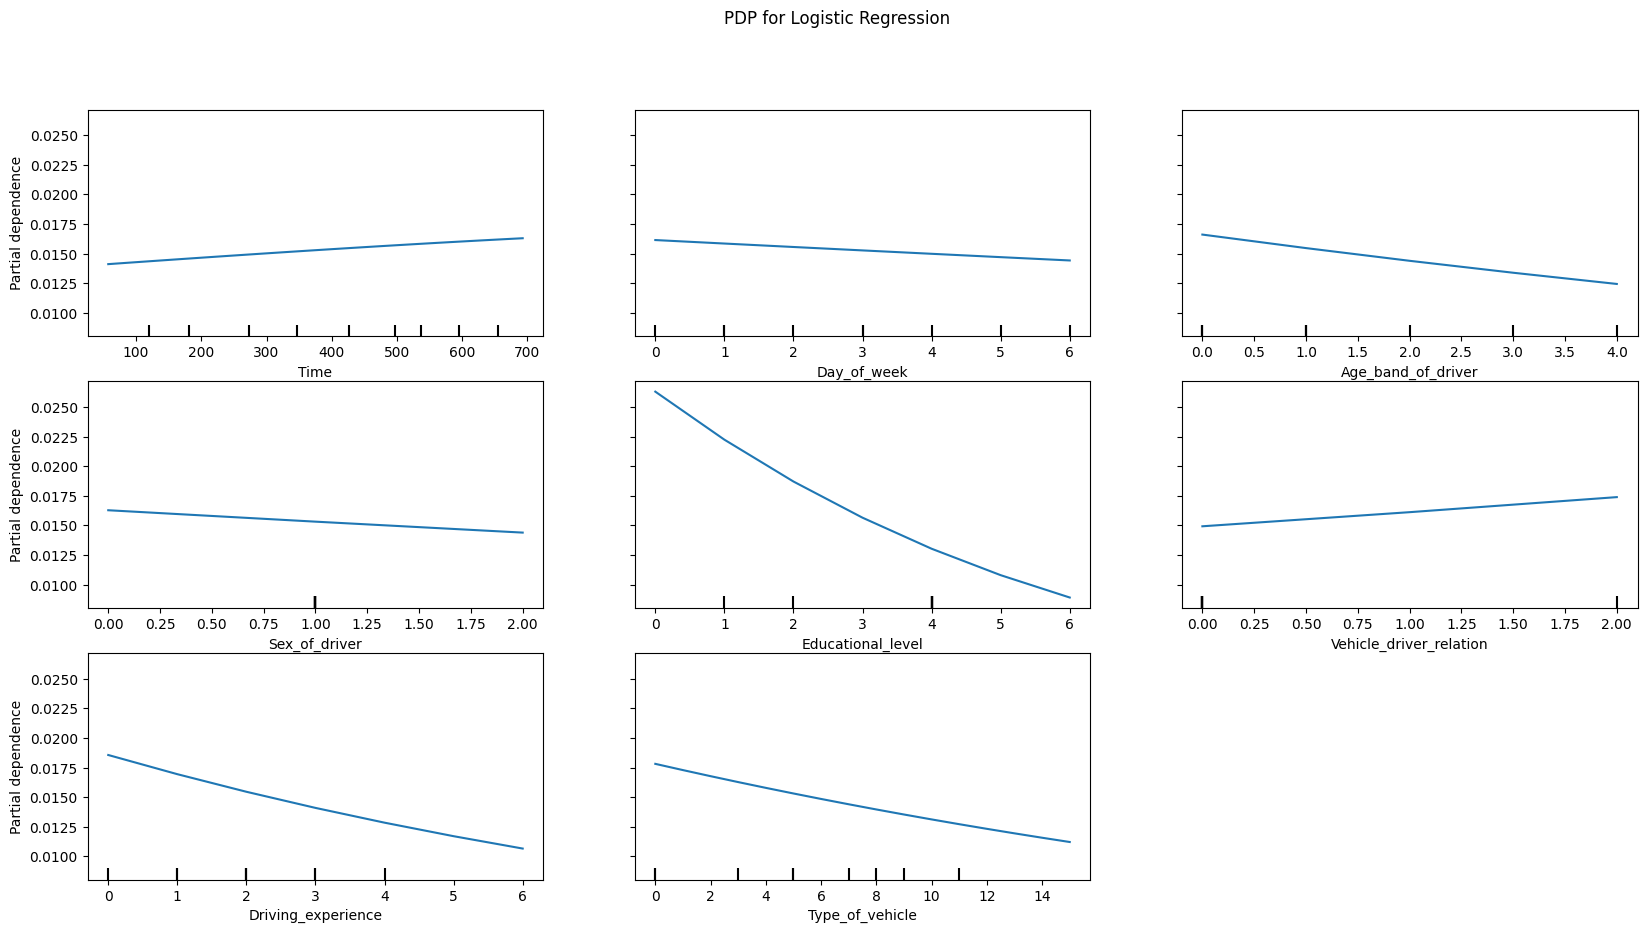

Partial Dependence Plot for model: Decision Tree


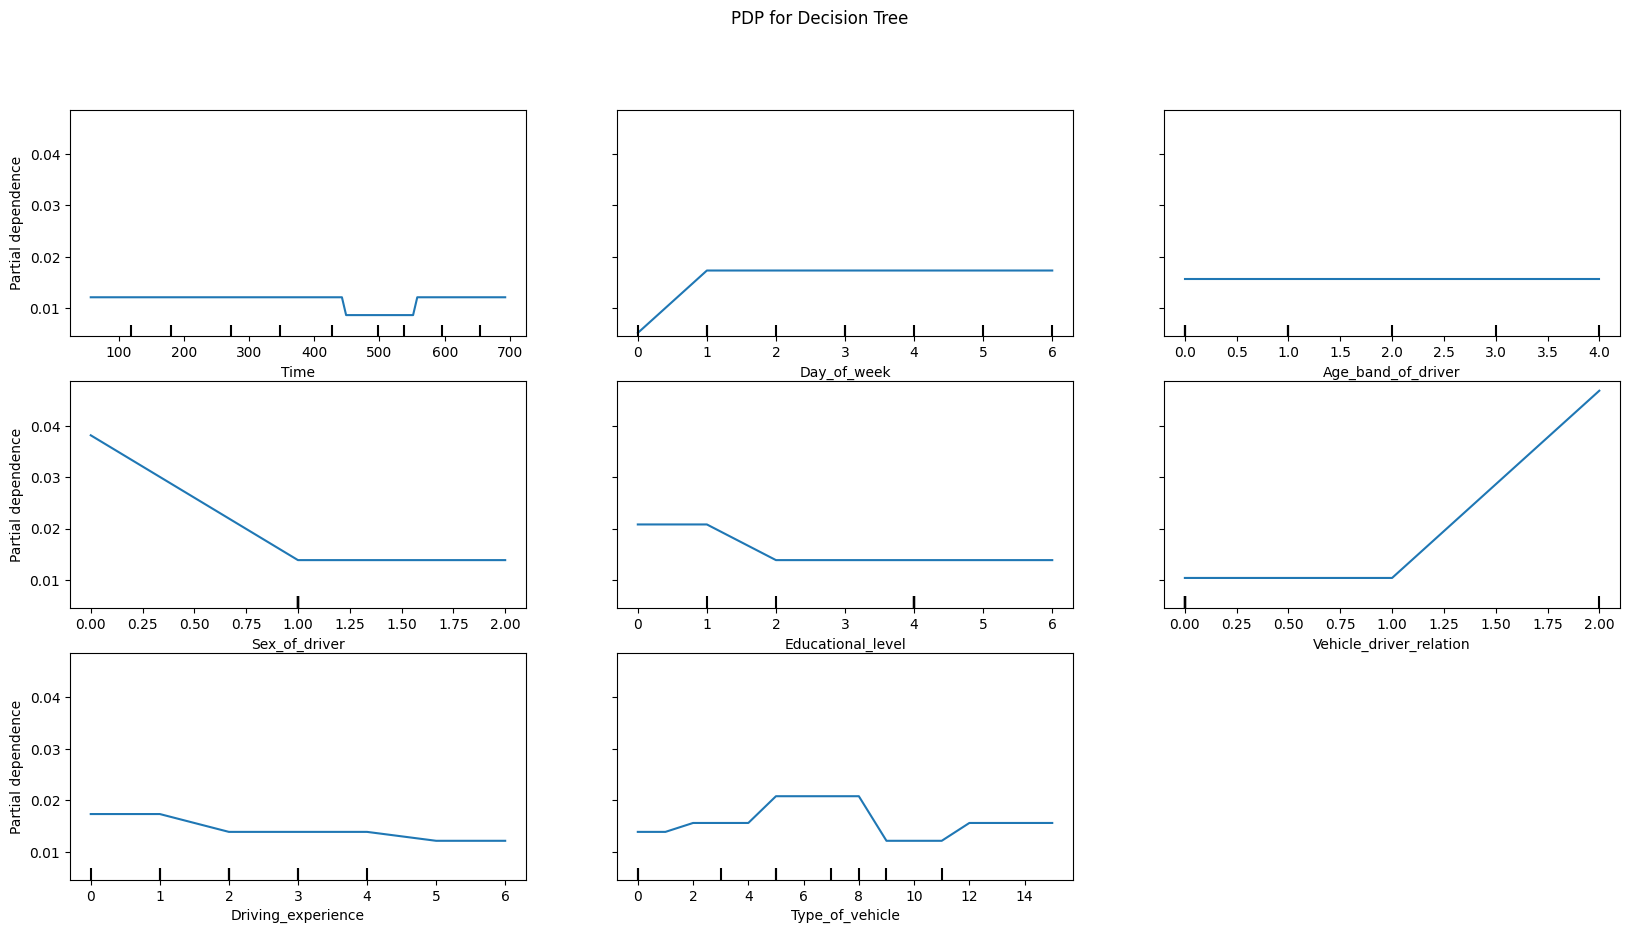

In [32]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay # Import PartialDependenceDisplay

# Feature(s) to plot for PDP
features = [0, 1, 2, 3, 4, 5, 6, 7]  # Replace with the indices or names of features you want to inspect
# Loop through models to display PDPs
for model_name, model in models.items():
    print(f"Partial Dependence Plot for model: {model_name}")

    fig, ax = plt.subplots(figsize=(20, 10)) # Increased figure size
    # Add target parameter for multi-class models
    PartialDependenceDisplay.from_estimator(model, X_train, features=features, ax=ax, target=0) # Assuming you want to see PDP for class 0. Change as needed.
    plt.suptitle(f"PDP for {model_name}")
    plt.show()